In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=FutureWarning) # ignoring futurewarnings

### 1. Dataset Overview

In [101]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

with open(os.path.expanduser("~/.kaggle/kaggle.json"), "r") as f:
    kaggle_credentials = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']


api = KaggleApi()
api.authenticate()

competition = 'spaceship-titanic'
api.competition_download_files(competition, path='data/')


In [102]:
train = pd.read_csv("data/train.csv")
train.drop('Name', inplace=True, axis=1) # Since name is likely irrelevant
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 823.6+ KB


In [104]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Transported        2
dtype: int64

### 1.1 Columns and Descriptions

| Column            | Description                                                 |
|-------------------|-------------------------------------------------------------|
| **PassengerId**   | id in the form of gggg_pp, gggg indicating a group and pp the number in the group |
| **HomePlanet**    | origin of passengers (Earth, Europa, Mars). only 3 values.  |
| **CryoSleep**     | boolean: were they in cryosleep?                            |
| **Cabin**         | cabin info (split into deck, num, and side).                |
| **Destination**   | intended destination (e.g., TRAPPIST-1e).                   |
| **Age**           | passenger's age.                                            |
| **VIP**           | boolean: paid for special services.                         |
| **RoomService** → **VRDeck** | amount spent on various facilities.              |
| **Transported**   | target: were they transported to an alternate dimension?    |

### 1.2 Future Hypotheses to explore
- Can people in cryosleep (variable = 1) still spend on various facilities?
- If the ship collided midway, does destination really affect if they were transported? If it does, does it vary proportionally across different destinations?

### 2. Feature Exploration and Missing Values Analysis

In [105]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

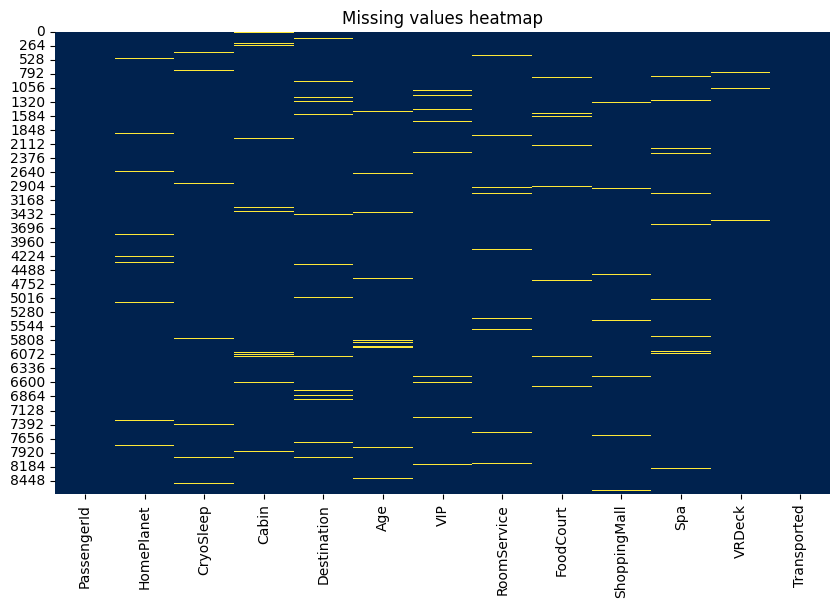

In [106]:
# Creating a heatmap to visualise missing values
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), cbar=False, cmap='cividis')
plt.title("Missing values heatmap")
plt.show()

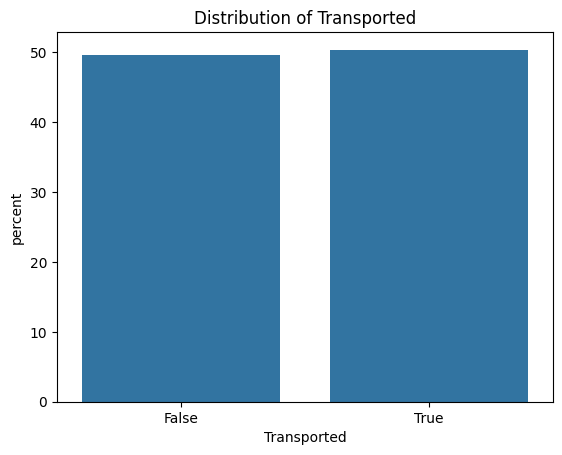

Chance of transportation in overall dataset: Transported
True     50.362361
False    49.637639
Name: proportion, dtype: float64
Chance of transportation given HomePlanet is missing: 0.512
Chance of transportation given CryoSleep is missing: 0.488
Chance of transportation given Cabin is missing: 0.503
Chance of transportation given Destination is missing: 0.505
Chance of transportation given Age is missing: 0.503
Chance of transportation given VIP is missing: 0.512
Chance of transportation given RoomService is missing: 0.459
Chance of transportation given FoodCourt is missing: 0.541
Chance of transportation given ShoppingMall is missing: 0.548
Chance of transportation given Spa is missing: 0.497
Chance of transportation given VRDeck is missing: 0.521


In [125]:
# Visualising distribution of Transported column
sns.countplot(train, x="Transported", stat="percent")
plt.title('Distribution of Transported')
plt.show()

percentage = train['Transported'].value_counts(dropna=False, normalize=True)*100
print(f'Chance of transportation in overall dataset: {percentage}')

# Calculating the proportion of people being transported if they have missing values in each column
for col in train.columns:
    if train[col].isnull().sum() > 0:
        transport_rate = train[train[col].isna()]['Transported'].mean()
        print(f'Chance of transportation given {col} is missing: {transport_rate:.3f}')

For all relevant columns, it is almost a probability of 0.5. It means that for any passengers with missing values, it is still almost 50% chance the passenger is transported. This implies that missing values do not correlate with the target being missing.

#### 2.1 PassengerId
Since the passenger id takes the form of gggg_pp, where gggg indicates the group of passengers while pp indicates the passenger number. This would require splitting the string into the group and passenger sections. Potential imputations could include considering passengers who are alone vs those who travel in groups.

#### 2.2 HomePlanet, Destination, CryoSleep, VIP
Next we deal with the categorical columns. HomePlanet and Destination are ternary variables, while CryoSleep and VIP are binary variables, so we will deal with them separately.


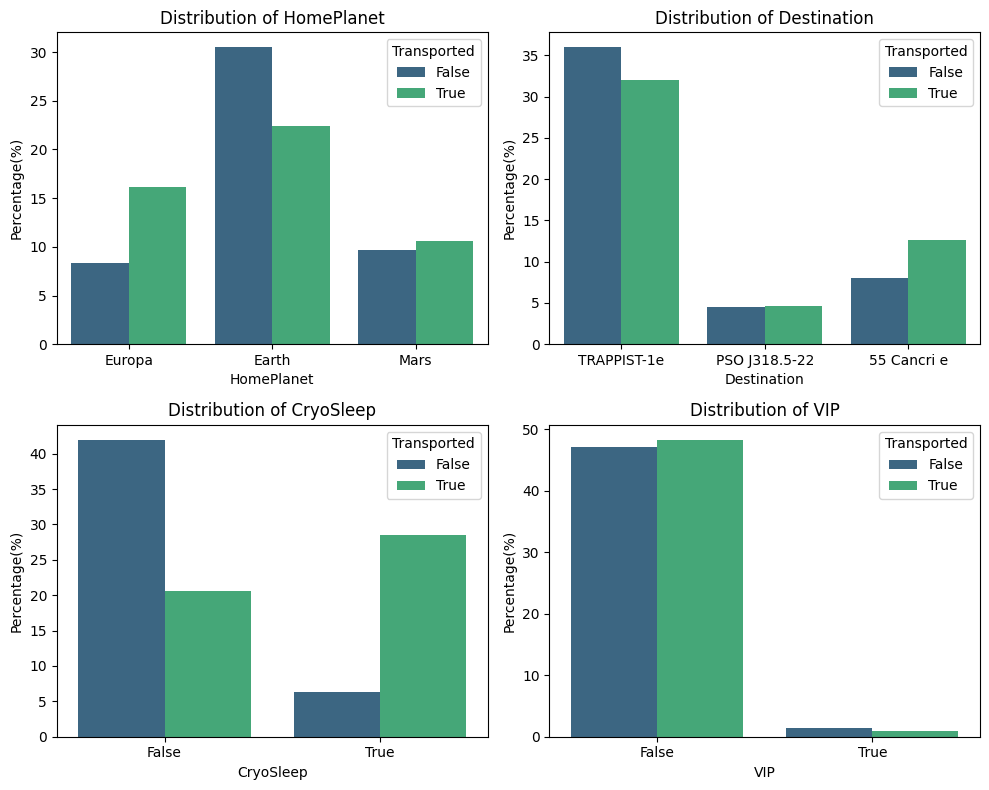

In [123]:
categorical_features = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP'] 

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, feature in enumerate(categorical_features):
    ax = axes[i//2, i%2]
    sns.countplot(data=train, x=feature, palette='viridis', ax=ax, stat='percent', hue='Transported')
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Percentage(%)')

plt.tight_layout()
plt.show()

Majority of the passengers come from the planet Earth, while most of their destinations is TRAPPIST-1e. More passengers were not in CryoSleep, while very few passengers had VIP status.

For missing values in HomePlanet and Destination, the easiest choice would be to impute them as the mode of the variables, i.e. Earth and TRAPPIST-1e respectively, this ensures no data is lost due to missing values. Further investigation during feature engineering would be needed to evaluate if this would introduce more bias or if more sophisticated methods are required.

As for CryoSleep and VIP, since they are binary variables, there is some intuition behind them having missing values. If a person's CryoSleep is missing, it could imply that they were not in cryosleep, while people who have empty values in VIP could mean that they were not VIPs. For the columns RoomService to VRDeck, it could mean that they spent 0 on those services, but whether or not these are true remain to be tested.

In [152]:
# Testing if CryoSleep = False affects transportation rate
cryosleep_transport_rate_before = train[(train['CryoSleep'].notna()) & (train['CryoSleep'] == False)]['Transported'].mean()
cryosleep_transport_rate_before = round(cryosleep_transport_rate_before, 4)
print('Before:', cryosleep_transport_rate_before)

traincryo = train.copy(deep=True)
traincryo['CryoSleep'].fillna(False, inplace=True)
cryosleep_transport_rate_after = traincryo[traincryo['CryoSleep'] == False]['Transported'].mean()
cryosleep_transport_rate_after = round(cryosleep_transport_rate_after, 4)
print('After:', cryosleep_transport_rate_after)

Before: 0.3289
After: 0.335


The transportation rate for Cryosleep = False increased less than 1% from 0.3289 to 0.3350, while the rate for Cryosleep = True remained constant. This implies that the distribution of the passengers with missing CryoSleep values largely aligns with the original distribution of passengers, and we can reasonably fill missing values with False during feature engineering.

A similar hypothesis is then tested for VIP column.

In [155]:
# Testing if VIP = False affects transportation rate
vip_transport_rate_before = train[(train['VIP'].notna()) & (train['VIP'] == False)]['Transported'].mean()
vip_transport_rate_before = round(vip_transport_rate_before, 4)
print('Before:', vip_transport_rate_before)

trainvip = train.copy(deep=True)
trainvip['VIP'].fillna(False, inplace=True)
vip_transport_rate_after = trainvip[trainvip['VIP'] == False]['Transported'].mean()
vip_transport_rate_after = round(vip_transport_rate_after, 4)
print('After:', vip_transport_rate_after)

Before: 0.5063
After: 0.5065


Similarly, the transportation rate did not change significantly after setting null values with False, which further supports filling null values with False for the VIP column in feature engineering.

#### 2.3 Cabin
The column Cabin comes in the form of deck/num/side, where deck and side are categorical variables while num stands for cabin number, which is continuous. We shall split Cabin into 3 columns and drop the original column since it provides no information by itself.

In [128]:
traincabin = train.copy(deep=True)
traincabin[['Deck', 'Number', 'Side']] = traincabin['Cabin'].str.split('/', expand=True)
traincabin.drop('Cabin', inplace=True, axis=1)
traincabin['Number'] = pd.to_numeric(traincabin['Number'], errors='coerce')
traincabin.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Number,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0.0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1.0,S


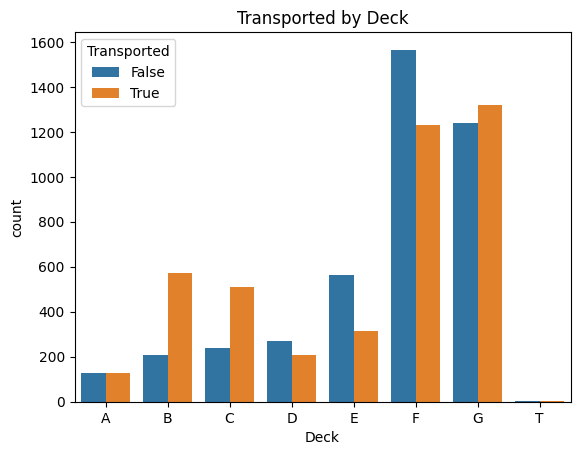

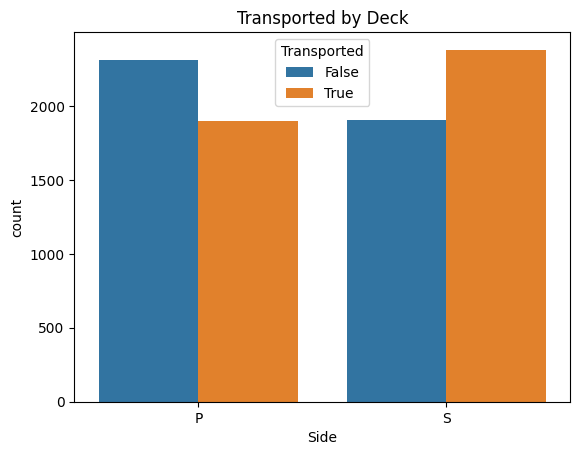

In [ ]:
# Count plots for Deck and Side
traincabin_sorted = traincabin.sort_values(by='Deck', ascending=True)
sns.countplot(traincabin_sorted, x='Deck', hue='Transported')
plt.title('Transported by Deck')
plt.show()

sns.countplot(traincabin, x='Side', hue='Transported')
plt.title('Transported by Deck')
plt.show()

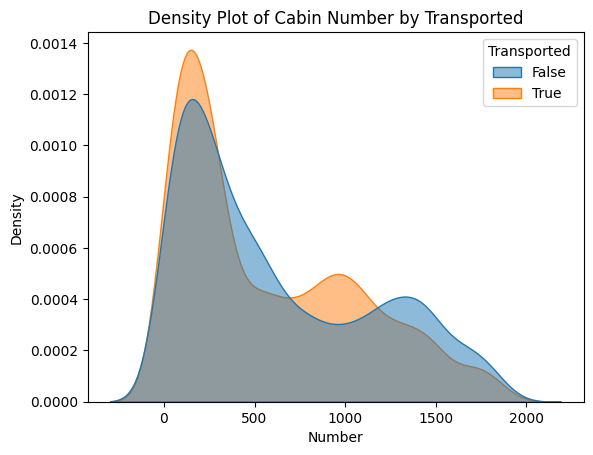

In [ ]:
# KDE plot for Number by Transported
sns.kdeplot(data=traincabin, x='Number', hue='Transported', fill=True, common_norm=False, alpha=0.5)
plt.title('Density Plot of Cabin Number by Transported')
plt.xlabel('Number')
plt.ylabel('Density')
plt.show()

As seen from the count plots, Deck F and G were the most crowded, while passengers were split equally the port and starboard side of the deck. However, it can be noted that Decks B and C had disproportionately higher transportation rate, while those who were on the starboard side had a greater tendency to be transported. For passengers with missing values, the mode or median would be a preliminary imputation strategy but further validation would have to be done in feature engineering.

From the KDEplot, it can be seen that there is a sharp peak in between Cabin Number 0-600 for both curves, while passengers with higher cabin numbers (about >1150) were slightly more likely not to be transported. This indicates the possibility of splitting up cabin number into tentative subgroups like low (0 to 600), medium (600-1150), high (> 1150) for easier analysis during feature engineering. Passengers with missing cabin numbers can be assigned a median or mode but further validation would again have to be done in feature engineering.

#### 2.4 Age
The age of passengers is a continuous one and is quite likely to affect the transportation rate. Questions like "Could there have been policies to evacuate the young and old?" come to my mind and we shall test for this by visualising the age distribution.

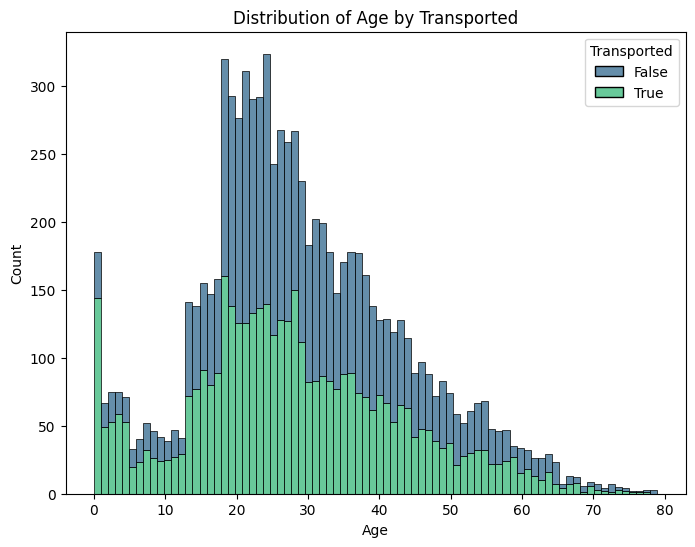

In [147]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train, x='Age', bins=80, hue='Transported', multiple='stack', palette='viridis')
plt.title('Distribution of Age by Transported')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

As seem from the histogram, majority of the passengers are in the age range of 20-30 years. The histograms have similar distributions, but the number of passengers who are transported are consistently lower than those who are not at each age. For feature engineering, a possible strategy to split up the age is into ranges such as Young (0-15), Adult (16-45), Old (>45). 

To deal with missing values, two possible strategies can be employed. The first is to impute any missing values with the median or mean, but an alternative that can be explored is to impute missing values with the mean age of a group from the PassengerId column, but the whole sample mean or median if the passenger is alone. Doing so will prevent loss of information from missing data, and capture patterns such as families travelling together.

#### 2.5 RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
These columns represent the amount spent on each feature, and are very likely to be continuous and skewed.

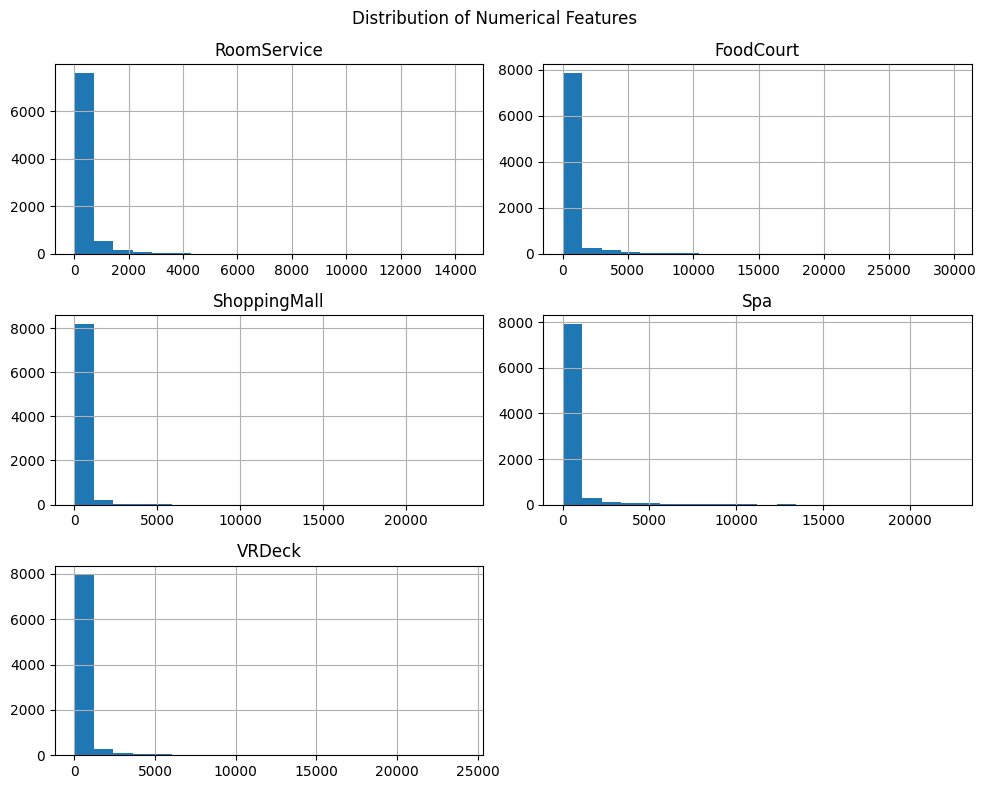

In [142]:
numerical_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train[numerical_features].hist(figsize=(10, 8), bins=20)
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout()
plt.show()

As seen from each histogram, the distributions are all right-skewed, which would make it hard for the model to analyse the effect of expenditure on any of these features. Hence, a log-transformation would be necessary during feature engineering to help normalise the distributions and reduce skewness.

As for missing values, we shall test the hypothesis if we can impute them as having 0 spending.

In [ ]:
# Testing if missing spending variables (RoomService to VRDeck) can be imputed as 0
def missing_spending(data, col):
    before = data[(data[col].notna()) & (data[col] == 0)].groupby(col)['Transported'].mean()
    before = round(before[0], 3)
    
    newdata = data.copy(deep=True)
    newdata[col].fillna(0, inplace=True)
    after = newdata[newdata[col] == 0].groupby(col)["Transported"].mean()
    after = round(after[0], 3)
    
    print(f"{col}:\nBefore: {before}, After: {after}")
    if abs(before-after) < 0.01:
        print(f'No significant difference (less than 0.01) after changing missing values in column {col} to 0')
    else:
        print(f'Significant difference, should not change missing values in column {col} to 0')

important_cols = train.columns[[i for i in range(7, 12)]]
for col in important_cols:
    missing_spending(train, col)

RoomService:
Before: 0.633, After: 0.628
No significant difference (less than 0.01) after changing missing values in column RoomService to 0
FoodCourt:
Before: 0.591, After: 0.589
No significant difference (less than 0.01) after changing missing values in column FoodCourt to 0
ShoppingMall:
Before: 0.599, After: 0.597
No significant difference (less than 0.01) after changing missing values in column ShoppingMall to 0
Spa:
Before: 0.639, After: 0.634
No significant difference (less than 0.01) after changing missing values in column Spa to 0
VRDeck:
Before: 0.628, After: 0.624
No significant difference (less than 0.01) after changing missing values in column VRDeck to 0


Since changing the missing values in all the spending columns to 0 does not significantly affect the transportation rate, it is same to assume that we can impute all missing values as 0 for these 5 columns during feature engineering.

### Correlation Analysis

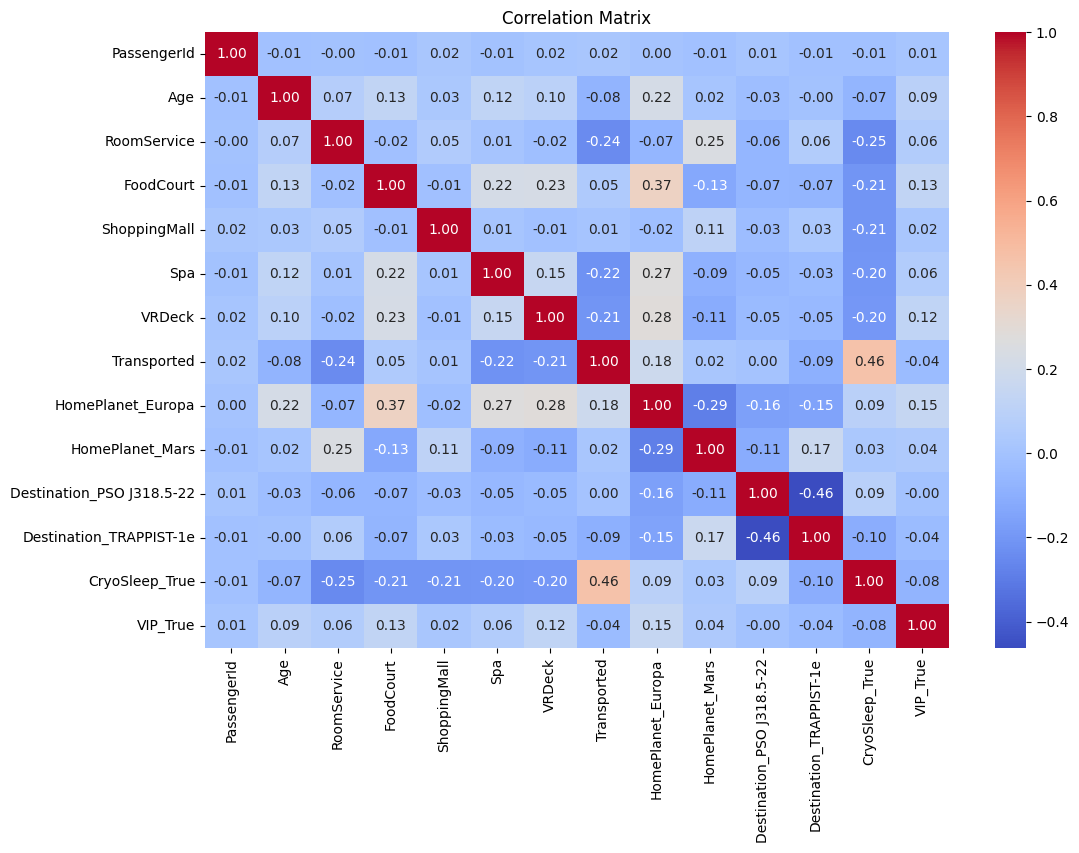

In [159]:
# Encoding categorical variables as numerical
encoded_data = pd.get_dummies(train[['HomePlanet', 'Destination', 'CryoSleep', 'VIP']], drop_first=True)
train_encoded = pd.concat([train.drop(columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin'], axis=1), encoded_data], axis=1)

# Creating a correlation matrix
corr_matrix = train_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Passengers in Cryosleep have a significantly high correlation with being transported at 0.46, indicating that passengers who are in cryosleep are likely to be transported. The other variables generally show a weak correlation with transported, apart from 3 of the 5 spending variables which show a decent negative correlation with transported.

## Summary



To conclude my findings, these are the highlights from the data that I have discovered.

1. PassengerId might be relevant by splitting into alone and group categories. Grouping passengers who share the same group prefix can identify families or groups travelling together. This can test whether being alone affects transportation rate.

2. Within the categorical variables, CryoSleep holds relative greater importance in whether a passenger is transported or not, as seen from the transportation rates and distribution patterns. Feature importance tests using random forests could validate this claim.

3. To deal with missing values for the categorical values, we can impute them as the mode if they are ternary variables, and 0 if they are binary variables like CryoSleep and VIP. For ternary variables, mode imputation ensures that missing values are consistent with the majority, while imputing as 0 for binary variables was supported by hypothesis testing, which showed no significant impact on transportation rates.

4. For the continuous variables on expenditure, we can impute all missing values as 0 since doing so does not significantly affect the transportation rate. Hypothesis testing showed that imputing missing values with 0 resulted in a less than 0.01 difference in transportation rates for all expenditure columns. During feature engineering, a log transformation also has to be applied to reduce right-skewing, and standardisation or normalisation might need to be applied also.

5. For columns like Age, it can be split into Young (0–15), Adult (16–45), and Old (>45) based on observed patterns and logical age brackets. This helps the model simplify analysis, and can be tested by comparing model performance with and without them.

6. The Cabin column contains valuable information that can be split into 3, of which Deck and Side can be encoded as multiple dummy variables while Num can be split into subcategories e.g., Low (0–600), Medium (601–1150), High (>1150) based on the KDE plot. Missing values can be imputed using mode for Deck and Side, while Num could be imputed using mean or median of the whole sample.